In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/valid/002_1024_jpeg.rf.b8c41940cb8dd4fa61e92892345859ad.jpg
/kaggle/input/face-mask-detection/valid/stock-photo-mother-and-her-daughter-walking-go-to-school-with-wearing-a-protection-mask-against-pm-air-1346870465_jpg.rf.a6b929aae5f5f3dc8beac91039f8c85a.jpg
/kaggle/input/face-mask-detection/valid/10fea_8011463765e2aa28b386cf_jpg.rf.0b90546b568e369f33ca67b3208b1655.jpg
/kaggle/input/face-mask-detection/valid/S1-EV360_FACEMA_M_20200130144349_jpg.rf.a641b3a9b315b4de3b3214da280cafab.jpg
/kaggle/input/face-mask-detection/valid/shutterstock_1145933543-e1579497052960_jpg.rf.f3807b96202c59d946e24047e52e92d0.jpg
/kaggle/input/face-mask-detection/valid/0ad90195-cd77-489e-bf85-08c83b80d3e0_jpg.rf.20ed8f759c47a565b60684cfd4524a21.jpg
/kaggle/input/face-mask-detection/valid/0109-00176-096b1_jpg.rf.c55de2d88f34d1217acdc245fd8292fa.jpg
/kaggle/input/face-mask-detection/valid/08_11_2019-airpollution_234_19737819_192539446_jpg.rf.113e45f57dba09fde40d8490ae957fe6.jpg
/k

Most of the given data set images contain more than one person,for for our model we need area cover by face(with mask or without mask) only not the entire image. We use the csv data set to crop only the required part and than load it, in the train, test and valid data frames.

In [2]:
def data_set(dir_data):
    data=[]
    target=[]
    data_map = {
    'with_mask':1,
    'without_mask':0
    }
    skipped=0
    root=dir_data+'_annotations.csv'
    df1 = pd.read_csv(root)
    df1.dataframeName = '_annotations.csv'
    nRow, nCol = df1.shape
    for i in range(len(df1)):
        without_mask='without_mask'
        k=dir_data+df1['filename'][i]
        image=cv2.imread(k)
        xmin=int(df1['xmin'][i])
        ymin=int(df1['ymin'][i])
        xmax=int(df1['xmax'][i])
        ymax=int(df1['ymax'][i])
        image=image[ymin:ymax,  xmin:xmax]
        try:
                # resizing to (70 x 70)
                image = cv2.resize(image,(70,70))
        except Exception as E:
                skipped += 1
                print(E)
                continue
        if(df1['class'][i]=='mask'):
            without_mask='with_mask'
        image=img_to_array(image)
        data.append(image)
        target.append(data_map[without_mask])
    data = np.array(data, dtype="float") / 255.0
    target = tf.keras.utils.to_categorical(np.array(target), num_classes=2)
    return data, target
training_data, training_target=data_set('/kaggle/input/face-mask-detection/train/')
testing_data, testing_target=data_set('/kaggle/input/face-mask-detection/test/')
valid_data, valid_target=data_set('/kaggle/input/face-mask-detection/valid/')

OpenCV(4.4.0) /tmp/pip-req-build-2mquh264/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'





Let's take a quick look at what the data looks like:


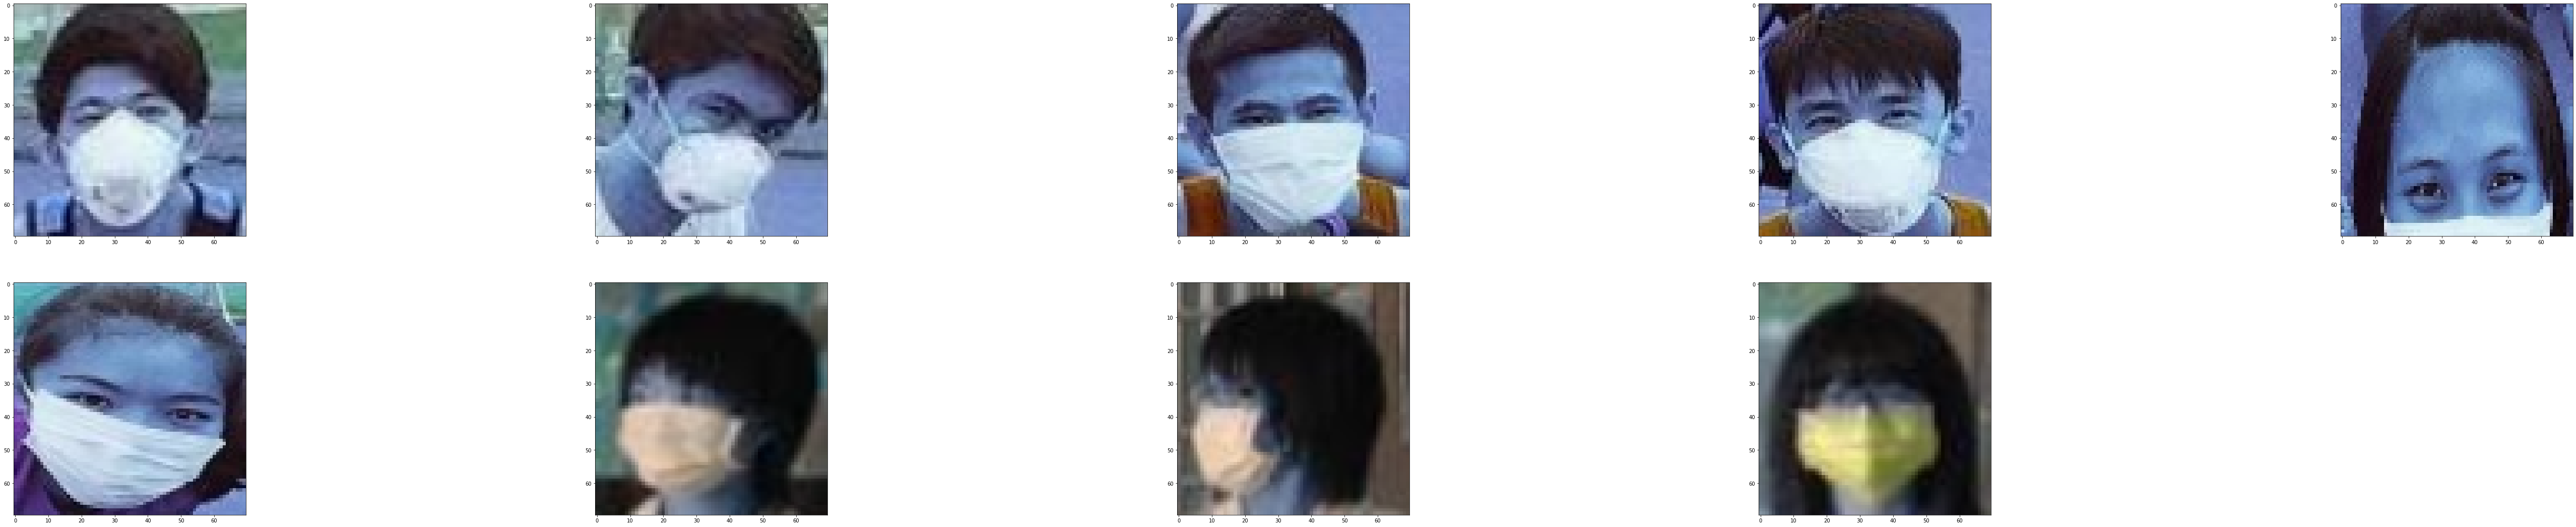

In [3]:
plt.figure(0, figsize=(100,100))
for i in range(1,10):
    plt.subplot(10,5,i)
    plt.imshow(training_data[i])

Now, we check the format of the images
channels_last=(row,col,channels)
channels_first=(channel,row,col)

In [4]:
img_shape=training_data[0].shape
depth, height, width=3, img_shape[0], img_shape[1]
img_shape=(height, width, depth)
chanDim=-1
if backend.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        img_shape = (depth, height, width)
        chanDim = 1

Building Model

In [5]:
model=Sequential()
model.add(layers.Conv2D(32,(3,3),input_shape=img_shape))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2,activation='softmax'))

adam =tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

check the summary of model

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0

Now we apply data augumentation for training our model with more data set which produce by modifying the same data set

In [7]:
# augmenting dataset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

Finally, we are ready to train our model.

In [8]:
history = model.fit(aug.flow(training_data, training_target, batch_size=10),
                   epochs=70,
                   validation_data=(valid_data, valid_target),
                   verbose=2,
                   shuffle=True) 

Epoch 1/70
70/70 - 5s - loss: 0.4683 - accuracy: 0.8216 - val_loss: 0.2567 - val_accuracy: 0.8765
Epoch 2/70
70/70 - 5s - loss: 0.3064 - accuracy: 0.8331 - val_loss: 0.2334 - val_accuracy: 0.9012
Epoch 3/70
70/70 - 4s - loss: 0.2896 - accuracy: 0.8475 - val_loss: 0.2070 - val_accuracy: 0.9259
Epoch 4/70
70/70 - 4s - loss: 0.2666 - accuracy: 0.8676 - val_loss: 0.2013 - val_accuracy: 0.9259
Epoch 5/70
70/70 - 4s - loss: 0.2551 - accuracy: 0.8791 - val_loss: 0.1784 - val_accuracy: 0.9444
Epoch 6/70
70/70 - 4s - loss: 0.2425 - accuracy: 0.8935 - val_loss: 0.1662 - val_accuracy: 0.9321
Epoch 7/70
70/70 - 4s - loss: 0.2589 - accuracy: 0.8950 - val_loss: 0.2177 - val_accuracy: 0.9012
Epoch 8/70
70/70 - 4s - loss: 0.2585 - accuracy: 0.8878 - val_loss: 0.1891 - val_accuracy: 0.9074
Epoch 9/70
70/70 - 4s - loss: 0.2347 - accuracy: 0.8978 - val_loss: 0.3050 - val_accuracy: 0.8889
Epoch 10/70
70/70 - 4s - loss: 0.1975 - accuracy: 0.9079 - val_loss: 0.1844 - val_accuracy: 0.9321
Epoch 11/70
70/70 -

let's plot a graph between accuracy of training and validation data set

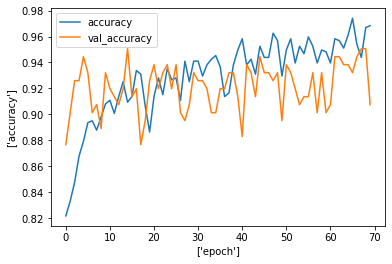

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel(['accuracy'])
plt.xlabel(['epoch'])
plt.legend(['accuracy', 'val_accuracy'])

let's plot a graph between loss of training and validation data set

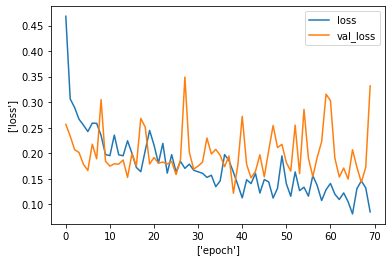

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel(['loss'])
plt.xlabel(['epoch'])
plt.legend(['loss', 'val_loss'])

Find loss and accuracy of our model

In [11]:
loss, accuracy = model.evaluate(testing_data,testing_target)
print('accuracy= ',loss," loss= ",loss)

3/3 [==============================] - 0s 27ms/step - loss: 0.3110 - accuracy: 0.9271
accuracy=  0.3110348880290985  loss=  0.3110348880290985


let's use our model on the testing data and get the report of our model

In [12]:
yhat = model.predict(testing_data)
test_pred=np.argmax(yhat,axis=1)
testing_target=np.argmax(testing_target,axis=1)

In [13]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import itertools
report = classification_report(testing_target, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.98      0.95      0.96        91

    accuracy                           0.93        96
   macro avg       0.68      0.77      0.71        96
weighted avg       0.95      0.93      0.93        96



confusion matrix

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdYlGn):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

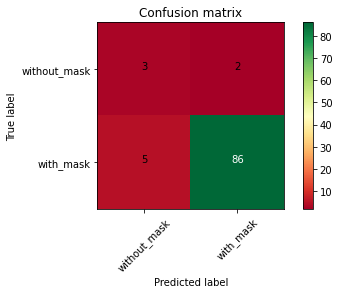

In [15]:
confusion = metrics.confusion_matrix(testing_target, test_pred)
plt.figure()
plot_confusion_matrix(confusion, classes=['without_mask','with_mask'], title='Confusion matrix')